In [1]:
import time
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
import matplotlib.pyplot as plt

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader

from nixtla.models.esrnn.esrnn import ESRNN

In [2]:
from nixtla.data.datasets.epf import EPF, EPFInfo
Y_df, X_df, _ = EPF.load(directory='../data', group=EPFInfo.groups[0])

X_df = X_df[['unique_id', 'ds', 'Exogenous1', 'Exogenous2', 'week_day']]

epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_in_test=24)
epf_dataset_full = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_in_test=0)

In [3]:
train_loader = TimeSeriesLoader(ts_dataset=epf_dataset,
                                model='esrnn',
                                offset=0,
                                window_sampling_limit= 24*30,
                                input_size=7*24,
                                output_size=24,
                                idx_to_sample_freq=24,
                                complete_inputs=True,
                                complete_sample=False,
                                batch_size=1,
                                shuffle=True)
test_loader = TimeSeriesLoader(ts_dataset=epf_dataset_full,
                                model='esrnn',
                                offset=0,
                                window_sampling_limit= 24*30,
                                input_size=7*24,
                                output_size=24,
                                idx_to_sample_freq=24,
                                complete_inputs=True,
                                complete_sample=False,
                                batch_size=1,
                                shuffle=True)

In [4]:
esrnn = ESRNN(input_size=7*24,
              output_size=24,
              include_var_dict={'Exogenous1':[-8,-2,-1], 'Exogenous2':[-8,-2,-1], 'week_day':[-1]},
              t_cols=epf_dataset.t_cols,
              max_epochs=100,
              learning_rate=1e-3,
              lr_scheduler_step_size=30,
              lr_decay=0.9,
              per_series_lr_multip=1.0,
              gradient_eps=1e-8,
              gradient_clipping_threshold=20,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=200,
              testing_percentile=50,
              training_percentile=50,
              es_component='multiplicative',
              cell_type='LSTM',
              state_hsize=500,
              dilations=[[1, 2], [4, 8]],
              add_nl_layer=False,
              loss='SMYL',
              seasonality=[24, 168],
              random_seed=1,
              device='cpu')

In [5]:
esrnn.fit(train_ts_loader=train_loader, eval_epochs=10, verbose=True)

Infered frequency: H
=============== Training ESRNN  ===============

Epoch: 0, Time: 0.501, Insample loss: 0.16875
Epoch: 10, Time: 5.484, Insample loss: 0.13719
Epoch: 20, Time: 10.396, Insample loss: 0.12717
Epoch: 30, Time: 15.620, Insample loss: 0.12085
Epoch: 40, Time: 20.747, Insample loss: 0.11630
Epoch: 50, Time: 25.882, Insample loss: 0.11235
Epoch: 60, Time: 30.966, Insample loss: 0.10963
Epoch: 70, Time: 36.037, Insample loss: 0.10622
Epoch: 80, Time: 41.088, Insample loss: 0.10350
Epoch: 90, Time: 46.161, Insample loss: 0.10122


In [6]:
y_true, y_hat, y_mask = esrnn.predict(ts_loader=test_loader, eval_mode=True)

In [7]:
y_hat_flatten = y_hat[:,-20:,:].flatten()
y_hat_flatten.shape

(480,)

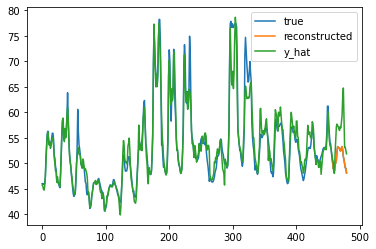

In [8]:
y_plot = Y_df['y'][-20*24:]
plt.plot(range(len(y_plot)), y_plot, label='true')
plt.plot(range(len(y_plot)-len(y_true[0,-1,:]),len(y_plot)), y_true[0,-1,:], label='reconstructed')
plt.plot(range(len(y_hat_flatten)), y_hat_flatten, label='y_hat')
plt.legend()